In [1]:
import pandas as pd
import plotly
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from math import sqrt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from matplotlib_dashboard import MatplotlibDashboard
import duckdb
import plotly.graph_objects as go
warnings.filterwarnings("ignore")

# Approach 

We don't know much about the difference of the 2 checkout files, and why they were put in different files. There is not much context about the data, but we know that it is small, specially for anomaly detection. We will try to compare the 2 files, and if they are similar, we will use both for further analysis. After that is resolved, then we will go to anomaly analysis.

In [2]:
checkout_1 = pd.read_csv('checkout_1.csv')
checkout_1['time'] = pd.to_datetime(checkout_1['time'], format='%Hh').dt.strftime('%H:%M')
checkout_1

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00:00,9,12,11,6.42,4.85
1,01:00,3,5,1,1.85,1.92
2,02:00,1,0,0,0.28,0.82
3,03:00,1,0,0,0.42,0.46
4,04:00,0,0,1,0.42,0.21
5,05:00,1,1,2,1.28,0.75
6,06:00,1,1,5,2.85,2.28
7,07:00,2,3,9,5.57,5.21
8,08:00,0,1,18,8.71,10.42
9,09:00,2,9,30,20.00,19.07


In [3]:
checkout_2 = pd.read_csv('checkout_2.csv')
checkout_2['time'] = pd.to_datetime(checkout_2['time'], format='%Hh').dt.strftime('%H:%M')
checkout_2

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00:00,6,9,5,5.000,4.92
1,01:00,3,3,2,2.000,1.92
2,02:00,3,1,2,0.420,0.75
3,03:00,0,1,1,0.420,0.46
4,04:00,0,0,0,0.140,0.21
5,05:00,2,1,1,0.710,0.71
6,06:00,3,1,2,1.420,2.10
7,07:00,10,2,9,3.000,5.03
8,08:00,25,0,12,3.710,9.82
9,09:00,36,2,27,10.140,17.64


# Simulating Distributions

We need to compare both files and check if they can be considered from the same POS and same context. In other words, if we are not mixing apples and oranges. The best way to do that is distribution analysis but the data points we have are too few for distribution analysis, specially because the different hours have different behaviors. We will use our few data points to add in a Standard Deviation, since we have the mean to compare. With the standard deviation and the mean, we can simulate a distribution with more data points, and compare both files.

We will be using the monthly average because it has a larger population and is closer to reality. Standard deviation is calculated using different days presented in the data (today, yesterday, same day last week). 
It is not ideal to use the monthly average to measure the standard deviation of 3 days of data, but it is what we have.

In [4]:

checkout_1['std_hour'] = ((checkout_1['today'] -  checkout_1['avg_last_month'])**2 +
                        (checkout_1['yesterday'] -  checkout_1['avg_last_month'])**2 +
                        (checkout_1['same_day_last_week'] -  checkout_1['avg_last_month'])**2) / (3-1)#n-1 (sample)

checkout_1['std_hour'] = np.sqrt(checkout_1['std_hour'])

In [5]:
checkout_2['std_hour'] = ((checkout_2['today'] -  checkout_2['avg_last_month'])**2 +
                        (checkout_2['yesterday'] -  checkout_2['avg_last_month'])**2 +
                        (checkout_2['same_day_last_week'] -  checkout_2['avg_last_month'])**2) / (3-1)#n-1 (sample)

checkout_2['std_hour'] = np.sqrt(checkout_2['std_hour'])

### Simulated Distributions of Sales from each file p/hour

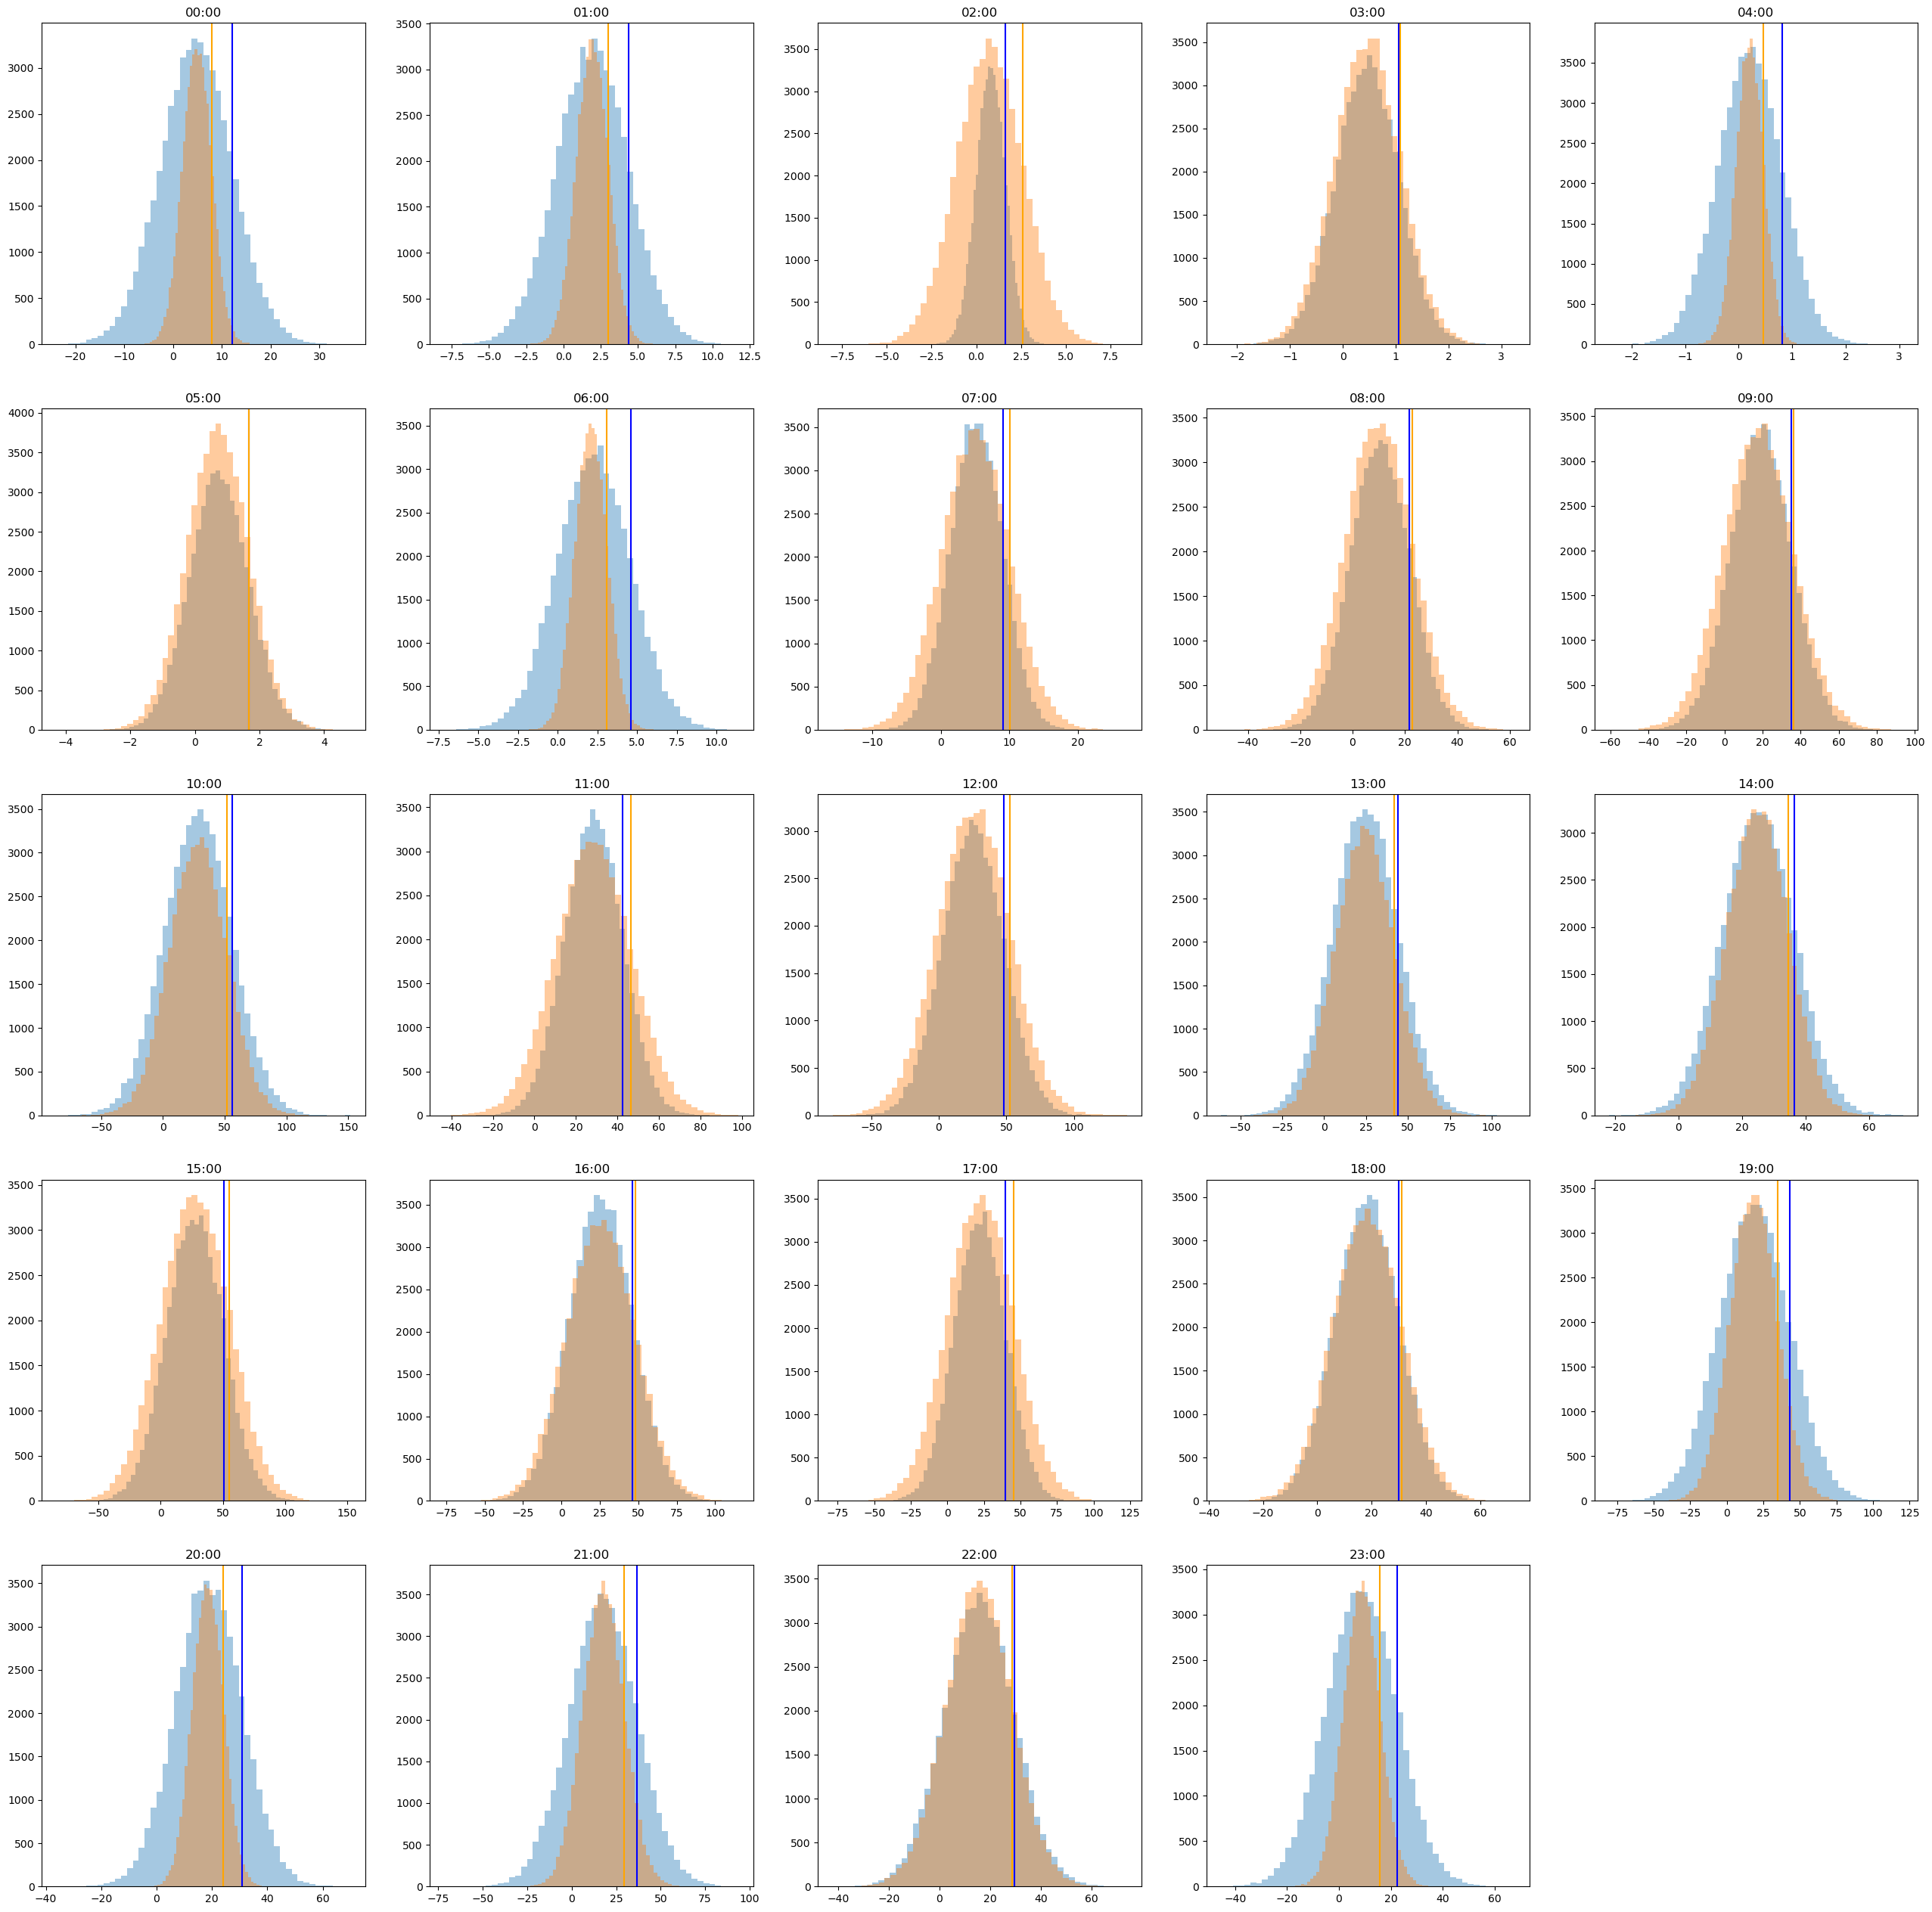

In [6]:



fig = plt.figure(figsize=(32,32))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in checkout_1.index: 
    avg = checkout_1.loc[i, 'avg_last_month']
    std = checkout_1.loc[i, 'std_hour']
    group_1 = np.random.normal(loc=avg, scale=std, size=50000)
    avg = checkout_2.loc[i, 'avg_last_month']
    std = checkout_2.loc[i, 'std_hour']
    group_2 = np.random.normal(loc=avg, scale=std, size=50000)

    ax = fig.add_subplot(5, 5, i+1)
    
    sns.distplot(group_1, kde=False, ax=ax)
    ax.axvline(np.mean(group_1) + np.std(group_1), color='blue')
    sns.distplot(group_2, kde=False, ax=ax)
    ax.axvline(np.mean(group_2) + np.std(group_2), color='orange')
    
    ax.set_title(str(checkout_1.loc[i, 'time']))


plt.show()


In [7]:
for i in checkout_1.index: 
    avg = checkout_1.loc[i, 'avg_last_month']
    std = checkout_1.loc[i, 'std_hour']
    group_1 = np.random.normal(loc=avg, scale=std, size=50000)
    avg = checkout_2.loc[i, 'avg_last_month']
    std = checkout_2.loc[i, 'std_hour']
    group_2 = np.random.normal(loc=avg, scale=std, size=50000)

    time = str(checkout_1.loc[i, 'time'])
    
    mean_pct_diff = (np.mean(group_1) - np.mean(group_2)) / ((np.mean(group_1) + np.mean(group_2)) / 2)
    std_pct_diff = (np.std(group_1) - np.std(group_2)) / ((np.std(group_1) + np.std(group_2)) / 2)
    
    mean_pct_diff = mean_pct_diff * 100
    std_pct_diff = std_pct_diff * 100

    mean_pct_diff = round(mean_pct_diff, 2)
    std_pct_diff = round(std_pct_diff, 2)

    print(f'{time} | Pct% difference between means = {mean_pct_diff}% \t | Pct% difference of Standard Deviations = {std_pct_diff}%')
    

00:00 | Pct% difference between means = -2.15% 	 | Pct% difference of Standard Deviations = 83.89%
01:00 | Pct% difference between means = -0.41% 	 | Pct% difference of Standard Deviations = 75.76%
02:00 | Pct% difference between means = 8.37% 	 | Pct% difference of Standard Deviations = -74.76%
03:00 | Pct% difference between means = 0.53% 	 | Pct% difference of Standard Deviations = -5.22%
04:00 | Pct% difference between means = -0.26% 	 | Pct% difference of Standard Deviations = 79.94%
05:00 | Pct% difference between means = 5.0% 	 | Pct% difference of Standard Deviations = -4.78%
06:00 | Pct% difference between means = 7.85% 	 | Pct% difference of Standard Deviations = 79.38%
07:00 | Pct% difference between means = 4.04% 	 | Pct% difference of Standard Deviations = -25.81%
08:00 | Pct% difference between means = 6.77% 	 | Pct% difference of Standard Deviations = -13.09%
09:00 | Pct% difference between means = 7.46% 	 | Pct% difference of Standard Deviations = -13.17%
10:00 | Pct% d

The mean of the distributions are very very close. Standard deviations sometimes are close, other times are very different, and this can be explained from the small amount of data we are using for this measurement, causing the standard deviations of each hour to be volatile.

In [8]:
print('Measures comparing checkouts, all hours')
print()
print(f'Variance of mean last month 1: {checkout_1["avg_last_month"].var()}')
print(f'Variance of mean last month 2: {checkout_2["avg_last_month"].var()}')
print()
print(f'Variance of STD 1: {checkout_1["std_hour"].var()}')
print(f'Variance of STD 2: {checkout_2["std_hour"].var()}')
print()
print(f'Variance of Today 1: {checkout_1["today"].var()}')
print(f'Variance of Today 2: {checkout_2["today"].var()}')
print()
print(f'STD of Today 1: {checkout_1["today"].std()}')
print(f'STD of Today 2: {checkout_2["today"].std()}')
print()
print(f'STD of day last week 1: {checkout_1["same_day_last_week"].std()}')
print(f'STD of day last week 2: {checkout_2["same_day_last_week"].std()}')

Measures comparing checkouts, all hours

Variance of mean last month 1: 107.4718427536232
Variance of mean last month 2: 107.84167807971015

Variance of STD 1: 71.08782774841202
Variance of STD 2: 81.20563711938512

Variance of Today 1: 376.7753623188406
Variance of Today 2: 278.8677536231884

STD of Today 1: 19.41070226238197
STD of Today 2: 16.699333927531015

STD of day last week 1: 17.239153279587182
STD of day last week 2: 15.813221399022174


**Conclusion**:  The checkout files are very similar in distribution, measures and numbers. It seems we can safely assume they are the same POS, maybe from different days. But for the rest of our analysis we will assume that different days are irrelevant, and the files are from the same POS.

Now we will use both files and try to detect anomalies

## Data Augmentation

 - **avg_last_month**: Average of *avg_last_month* from both files
 - **last_week_total_est (1 & 2)**: Estimate of total sales from that hour in the week, using *avg_last_week x 7*
 - **last_month_total_est**: Estimate of total sales from that hour in the last month, using *avg_last_month x 30*. Uses only avg from file 1 since both are very similar
 - **std_hour**: Standard deviation of sales from that hour, uses all data entries from singular days (today 1-2, yesterday 1-2, same_day_last_week 1-2) as data points for the calculation.
 - **Column Name _1 or _2**: Joined data columns from files 1 and 2 respectively

In [9]:
analysis_df = duckdb.query("""
SELECT chk1.time, chk1.today as today_1, chk1.yesterday as yesterday_1, chk1.same_day_last_week as same_day_last_week_1, chk2.today_2, chk2.yesterday_2
    , chk2.same_day_last_week_2, chk1.avg_last_week as avg_last_week_1, chk2.avg_last_week as avg_last_week_2, (chk1.avg_last_month + chk2.avg_last_month)/2 as avg_last_month 
    , chk1.avg_last_week * 7 as last_week_total_est1, chk1.avg_last_week * 7 as last_week_total_est2 , chk1.avg_last_month * 30 as last_month_total_est 
    , sqrt( 
        (chk1.today - chk1.avg_last_month)**2 +
        (chk2.today_2 - chk2.avg_last_month)**2 +
        (chk1.yesterday - chk1.avg_last_month)**2 +
        (chk2.yesterday_2 - chk2.avg_last_month)**2 +
        (chk1.same_day_last_week - chk1.avg_last_month)**2 +
        (chk2.same_day_last_week_2 - chk2.avg_last_month)**2 / (6-1)
        ) as std_hour
FROM checkout_1 as chk1
LEFT JOIN (select time,today as today_2, yesterday as yesterday_2,same_day_last_week as same_day_last_week_2, avg_last_week, avg_last_month from checkout_2) as chk2
ON chk1.time = chk2.time
             """).df()
analysis_df

,time,today_1,yesterday_1,same_day_last_week_1,today_2,yesterday_2,same_day_last_week_2,avg_last_week_1,avg_last_week_2,avg_last_month,last_week_total_est1,last_week_total_est2,last_month_total_est,std_hour
0,00:00,9,12,11,6,9,5,6.42,5.000,4.885,44.94,44.94,145.5,11.134702
1,01:00,3,5,1,3,3,2,1.85,2.000,1.920,12.95,12.95,57.6,3.719312
2,02:00,1,0,0,3,1,2,0.28,0.420,0.785,1.96,1.96,24.6,2.610498
3,03:00,1,0,0,0,1,1,0.42,0.420,0.460,2.94,2.94,13.8,1.129743
4,04:00,0,0,1,0,0,0,0.42,0.140,0.210,2.94,2.94,6.3,0.899622
5,05:00,1,1,2,2,1,1,1.28,0.710,0.730,8.96,8.96,22.5,1.858096
6,06:00,1,1,5,3,1,2,2.85,1.420,2.190,19.95,19.95,68.4,3.563313
7,07:00,2,3,9,10,2,9,5.57,3.000,5.120,38.99,38.99,156.3,8.160042
8,08:00,0,1,18,25,0,12,8.71,3.710,10.120,60.97,60.97,312.6,24.136787
9,09:00,2,9,30,36,2,27,20.00,10.140,18.355,140.00,140.00,572.1,33.338804


## Analysis

It seems there is a trend of sales follwoing the different times of day. Let's take the average of all the sales data related to single days (today, yesterday, same_day_last_week) and show it in a graph to better see this trend.

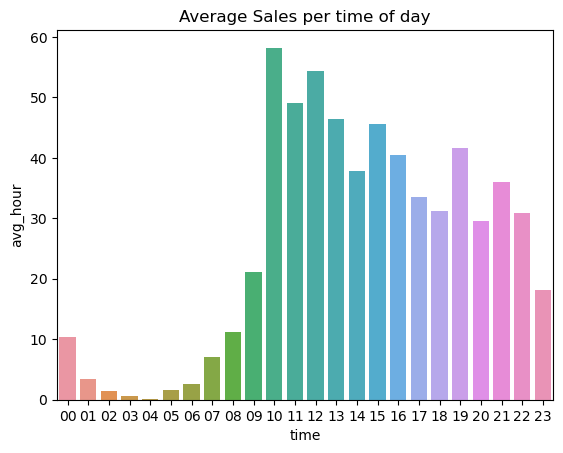

In [10]:
bar = duckdb.query("""
SELECT REPLACE(CAST(time as STRING),':00','') as time, SUM( (today_1 + today_2 + yesterday_1 + yesterday_2 + same_day_last_week_1 + same_day_last_week_2)/(6-1) ) as avg_hour
FROM analysis_df
GROUP BY time
""").df().sort_values('time')
sns.barplot(bar, x='time', y='avg_hour')
plt.title('Average Sales per time of day')
plt.show()

Let's see the trend for each individual day

In [11]:
lines = duckdb.query("""
SELECT REPLACE(CAST(time as STRING),':00','') as time, today_1, today_2, yesterday_1, yesterday_2, same_day_last_week_1, same_day_last_week_2
FROM analysis_df
""").df()



fig = go.Figure()
fig.add_trace(go.Scatter(x=lines.time, y=lines.today_1,
                    mode='lines',
                    name='today_1'))
fig.add_trace(go.Scatter(x=lines.time, y=lines.today_2,
                    mode='lines',
                    name='today_2'))
fig.add_trace(go.Scatter(x=lines.time, y=lines.yesterday_1,
                    mode='lines',
                    name='yesterday_1'))
fig.add_trace(go.Scatter(x=lines.time, y=lines.yesterday_2,
                    mode='lines',
                    name='yesterday_2'))
fig.add_trace(go.Scatter(x=lines.time, y=lines.same_day_last_week_1,
                    mode='lines',
                    name='same_day_last_week_1'))
fig.add_trace(go.Scatter(x=lines.time, y=lines.same_day_last_week_2,
                    mode='lines',
                    name='same_day_last_week_2'))

fig.show()



Clearly, the various days follow the same trend in sales through the hours. Except for **today_2** which is from the second file

Since we have the average following a trend, and the individual days following a trend, we should have a high correlation bewtween our different columns, and if we have an anomaly, it will affect the correlation.

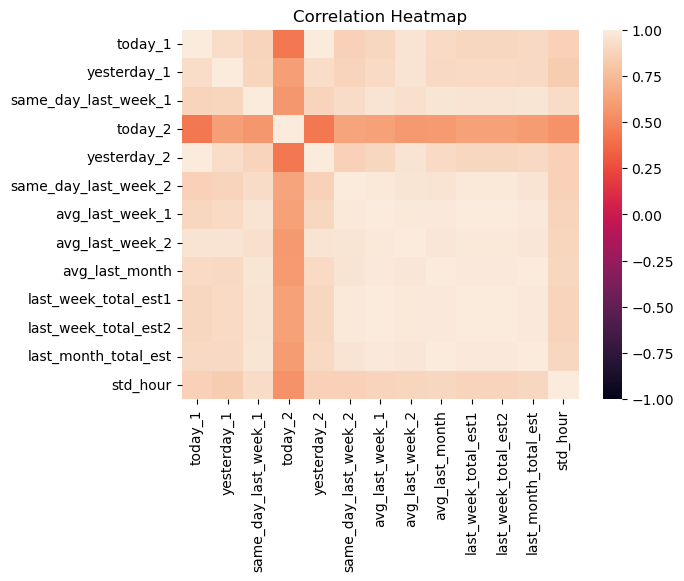

In [12]:
sns.heatmap(analysis_df.drop('time', axis=1).corr(), vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

And here we have it. *today_2* is the only variable that doesn't have a correlation very close to 1.

Just to reinforce the idea that this is an anomaly, we will compare all days to different averages side by side.

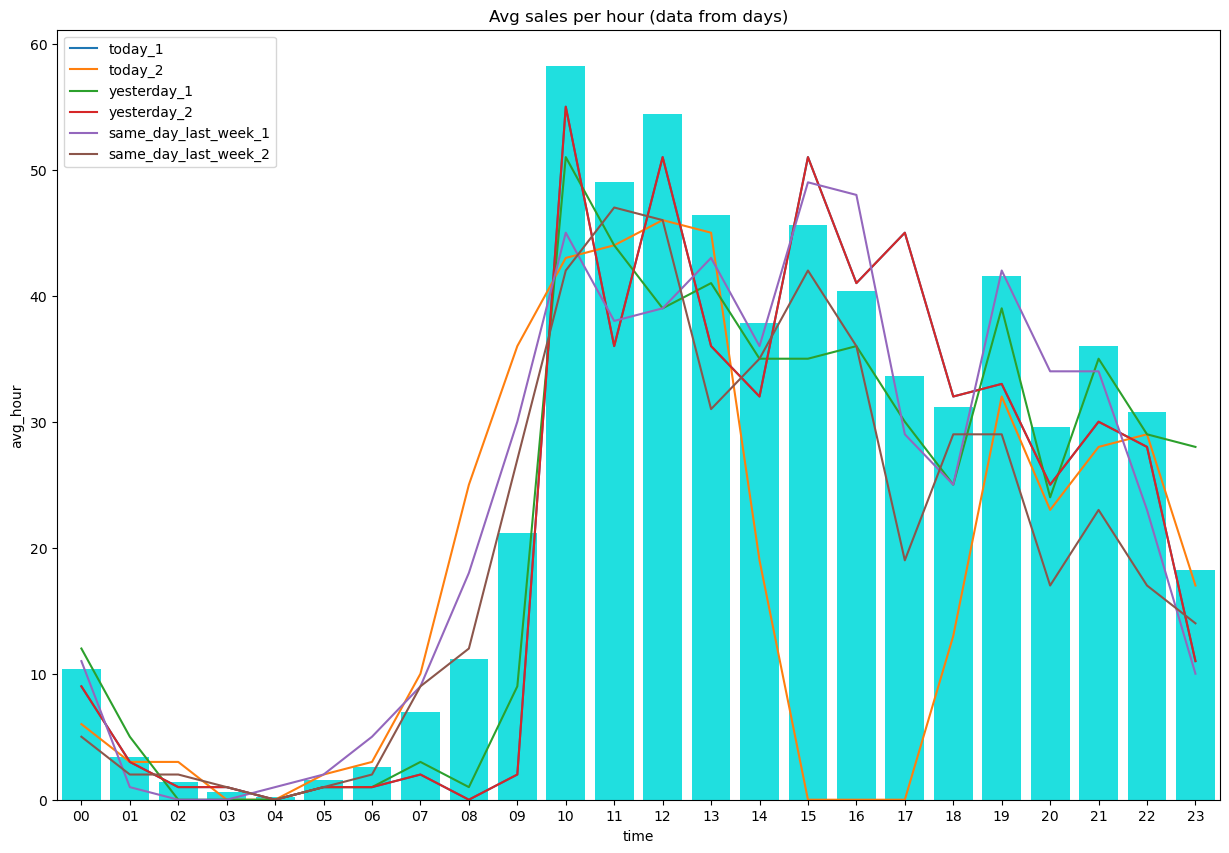

In [13]:
plt.figure(figsize=(15,10))
sns.lineplot(lines, x='time', y='today_1', label='today_1')
sns.lineplot(lines, x='time', y='today_2', label='today_2')
sns.lineplot(lines, x='time', y='yesterday_1', label='yesterday_1')
sns.lineplot(lines, x='time', y='yesterday_2', label='yesterday_2')
sns.lineplot(lines, x='time', y='same_day_last_week_1', label='same_day_last_week_1')
sns.lineplot(lines, x='time', y='same_day_last_week_2', label='same_day_last_week_2')
sns.barplot(bar, x='time', y='avg_hour', color='cyan')
plt.title('Avg sales per hour (data from days)')
plt.legend(loc="upper left")

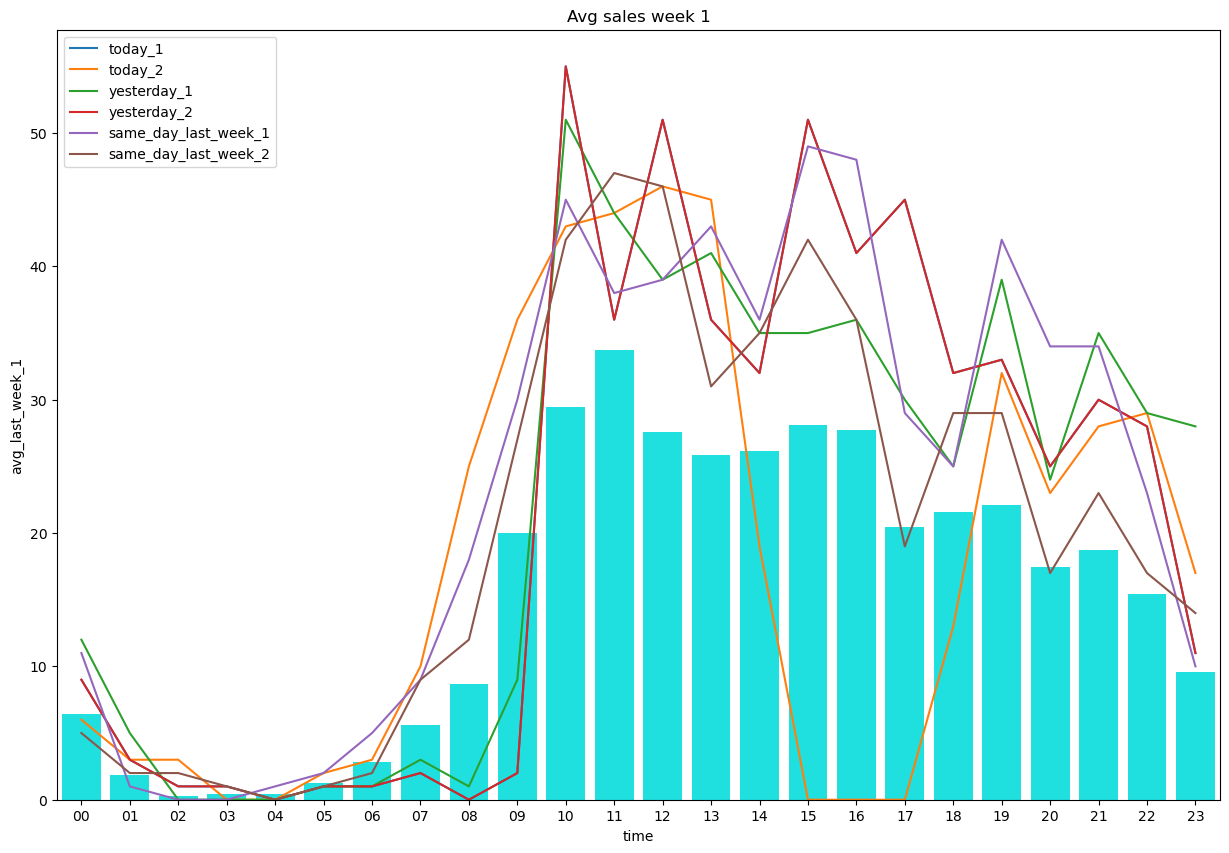

In [14]:
lines = duckdb.query("""
SELECT REPLACE(CAST(time as STRING),':00','') as time, avg_last_week_1, today_1, today_2, yesterday_1, yesterday_2, same_day_last_week_1, same_day_last_week_2
FROM analysis_df
""").df()

plt.figure(figsize=(15,10))
sns.lineplot(lines, x='time', y='today_1', label='today_1')
sns.lineplot(lines, x='time', y='today_2', label='today_2')
sns.lineplot(lines, x='time', y='yesterday_1', label='yesterday_1')
sns.lineplot(lines, x='time', y='yesterday_2', label='yesterday_2')
sns.lineplot(lines, x='time', y='same_day_last_week_1', label='same_day_last_week_1')
sns.lineplot(lines, x='time', y='same_day_last_week_2', label='same_day_last_week_2')
sns.barplot(lines, x='time', y='avg_last_week_1', color='cyan')
plt.title('Avg sales week 1')
plt.legend(loc="upper left")

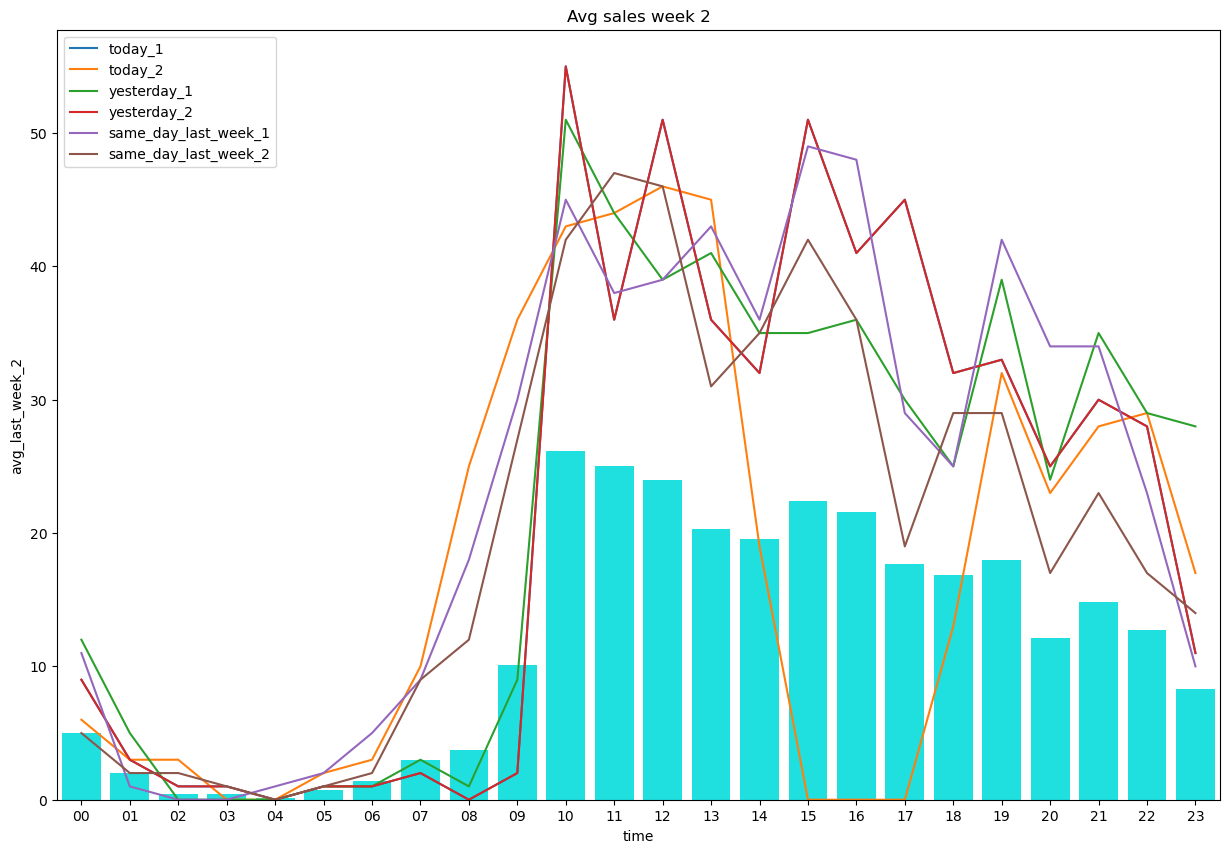

In [15]:
lines = duckdb.query("""
SELECT REPLACE(CAST(time as STRING),':00','') as time, avg_last_week_2, today_1, today_2, yesterday_1, yesterday_2, same_day_last_week_1, same_day_last_week_2
FROM analysis_df
""").df()

plt.figure(figsize=(15,10))
sns.lineplot(lines, x='time', y='today_1', label='today_1')
sns.lineplot(lines, x='time', y='today_2', label='today_2')
sns.lineplot(lines, x='time', y='yesterday_1', label='yesterday_1')
sns.lineplot(lines, x='time', y='yesterday_2', label='yesterday_2')
sns.lineplot(lines, x='time', y='same_day_last_week_1', label='same_day_last_week_1')
sns.lineplot(lines, x='time', y='same_day_last_week_2', label='same_day_last_week_2')
sns.barplot(lines, x='time', y='avg_last_week_2', color='cyan')
plt.title('Avg sales week 2')
plt.legend(loc="upper left")

If you look closely to the graphs, there is a trend from hour 14 to 15 where sales increase and then decrease. A better way to check and expose this better is to check the percentage change from row to row and compare the different variables.

Notes:
- *pandas.Dataframe.pct_change* creates NaNs and Infinites when zeros are involved.
    - For the first 0 after a number, pct_change will be -100%, we will forward this for Nans
    - The first number after a 0 will be Infinite, we will replace this with +100%

In [16]:
pct_changes = analysis_df.drop('time',axis=1).pct_change().fillna(method='ffill').replace([np.inf], 1.00)
pct_changes['time'] = analysis_df['time']

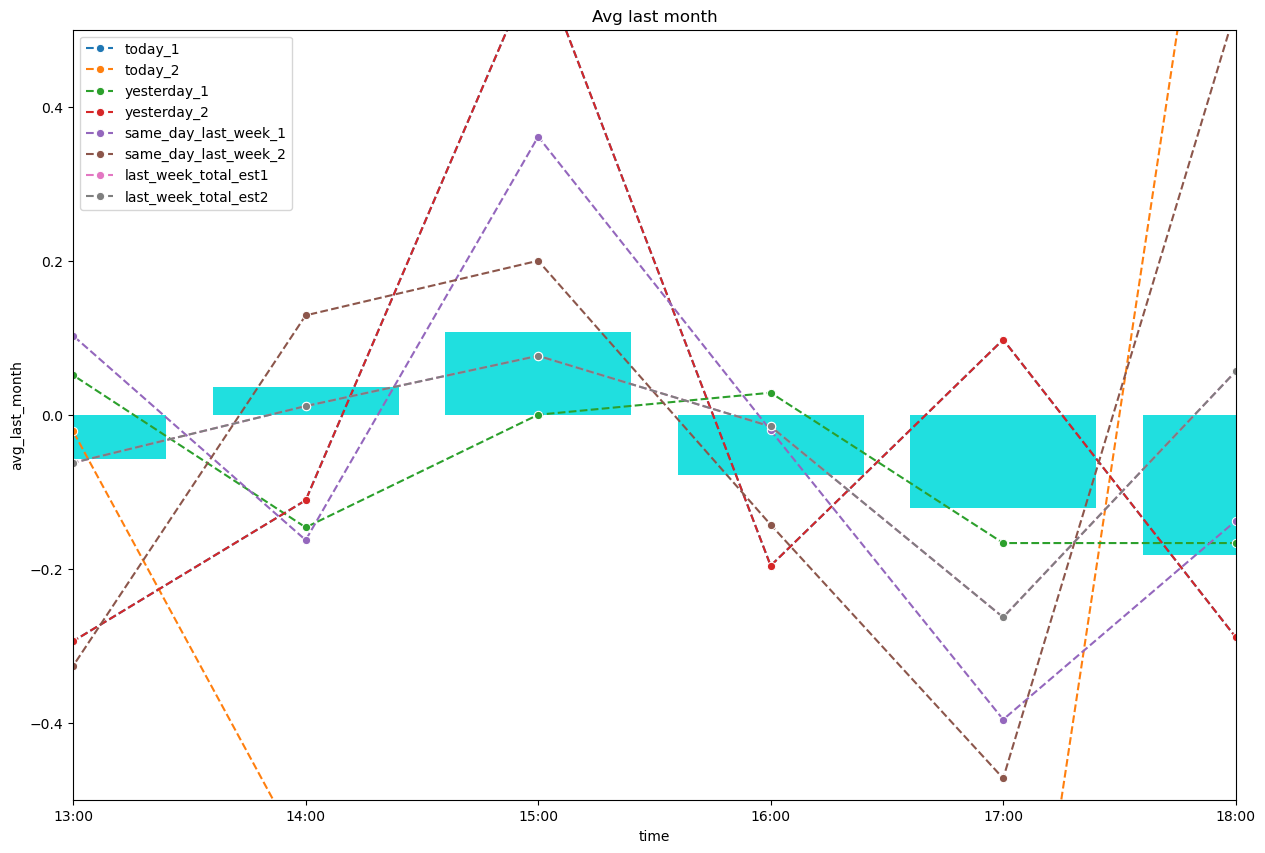

In [17]:
pct_change_analysis =pct_changes


plt.figure(figsize=(15,10))
sns.lineplot(pct_change_analysis, x='time', y='today_1', label='today_1', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='today_2', label='today_2', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='yesterday_1', label='yesterday_1', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='yesterday_2', label='yesterday_2', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='same_day_last_week_1', label='same_day_last_week_1', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='same_day_last_week_2', label='same_day_last_week_2', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='last_week_total_est1', label='last_week_total_est1', marker='o',linestyle="dashed")
sns.lineplot(pct_change_analysis, x='time', y='last_week_total_est2', label='last_week_total_est2', marker='o',linestyle="dashed")
ax = sns.barplot(pct_change_analysis, x='time', y='avg_last_month', color='cyan')
ax.set_ylim(-0.5,0.5)
ax.set_xlim(13,18)
plt.title('Avg last month')
plt.legend(loc="upper left")

As we can see here, all other variables we have on sales has a growth from hour 14 to 15, *except* today_2, which goes down to 0 sales and stays there for some hours. Thus proving further it is an anomaly, probably the POS went down for some time.

## Conclusion

We found that, in the *checkout_2* file, from hours 14 to 17 on the current day, there was most probably an anomaly. Indications of an anomaly are: 
- A clear and defined trend of sales in certain hours, in which the anomaly doesn't follow
- Big difference in numbers between anomalous data and other data from different days
- Lack of correlation, when other days on sales and other variables are highly correlated (reinforces arguments 1 and 2)

### Notes:

- It was also found that *yesterday_2* and *today_1* are exactly the same (see plotly graph). Which indicates that checkout_2 is from a day after checkout_1.
- Another somewhat anomalous behavior in the data is from *yesterday_2*, where from hours 9 to 10 sales went from 2 to 55, an increase of 2600%. Similar behavior was found in *yesterday_1* with 1000% increase. But that probably is just a consequence of very low sale hours going into peak sale hours.
- **AI and any machine learning models were discarded from start because data was too small**, focusing on using any model would only distract and confuse the analysis.
- With more data, a model to predict sales for each hour seems very possible